In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.integrate import quad, simpson
from sympy import *
from sympy.abc import i, x
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

Problem 3.1

In [27]:
def pdf_unnorm(x):
    return C*x**(-0.9)

xmin, xmax = 0.005, 1

In [28]:
C, x = symbols('C, x')

I = integrate(pdf_unnorm(x), (x, xmin, xmax))
C_val = solve(I-1, C)

print(C_val)

[0.243133909726934]


In [19]:
# Test if PDF is normalized
def pdf_like(x):
    return C_val[0]*x**(-0.9)

result = quad(pdf_like, xmin, xmax)
if round(result[0], 5) == 1:
    print(result[0])
    print('PDF is normalized')
else:
    print(result[0])
    print('PDF is NOT normalized')

1.0000000000000009
PDF is normalized


In [20]:
x1 = np.linspace(xmin, xmax, 10000)
x2 = np.linspace(0, 1, 10000)

C:\Users\nan25\AppData\Local\Temp\ipykernel_6824\2096376449.py:3: RuntimeWarning: divide by zero encountered in power
  return C_val[0]*x**(-0.9)


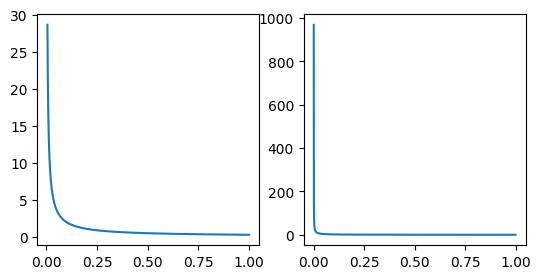

In [26]:
fig, ax = plt.subplots(1,2, figsize = (6.3, 3))

ax[0].plot(x1, pdf_like(x1))
ax[1].plot(x2, pdf_like(x2))

In [ ]:
# Both the transformation method and the accept-reject method can be used. They are equally valid.
# The transformation method is more efficient in generating random numbers, which is why I would use this method
# f(x) goes to infinty as x goes to zero for x in [0, 1], which is why the accept-reject method cannot be used

In [40]:
r = np.random
r.seed(42)

save_plots = True
N_points = 10000    # Number of random points to be generated

In [46]:
# Integrate f(x) from -infinity to x
x = Symbol('x')
xb = Symbol('xb')
F = integrate(pdf_like(xb), (xb,0.005,x))
print(F)

2.43133909726934*x**0.1 - 1.43133909726934


In [47]:
# Invert F(x)
inv = solve(F - i, x)
print(inv)

[0.00499999999999999*(0.698646464634248*i + 1)**10]


In [48]:
# Now produce random numbers using the inverse function found above
x_pdf_like = 0.00499999999999999*(0.698646464634248*r.uniform(size=N_points) + 1)**10

[0.05084736 0.04047146 0.0159601  ... 0.03424786 0.07426218 0.01557814]


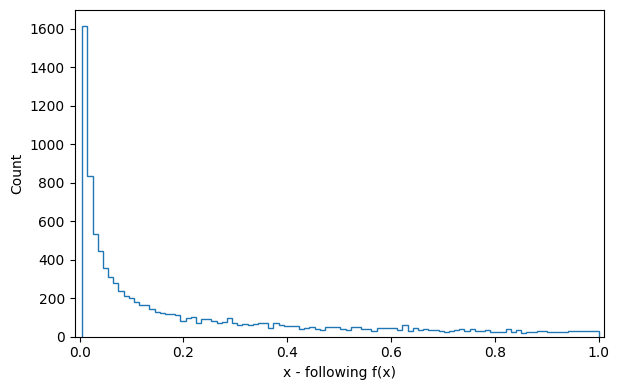

In [51]:
Nbins = int(N_points / 100)
binwidth = (xmax - xmin) / Nbins
print(x_pdf_like)
fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(x_pdf_like, bins=Nbins, range=(xmin, xmax), histtype='step', label='Histogram (generated)' )
ax.set(xlabel="x - following f(x)", ylabel="Count", xlim=(-0.01, 1.01))

fig.tight_layout()
fig.savefig('pdf_like_hist.png', dpi = 150)

In [54]:
N_experiments = 1000
N_t = 50
N3_sigma = 0  
x_t = np.zeros((N_t, N_experiments))
x_sum = np.zeros((N_experiments))

In [94]:
for iexp in range(N_experiments): 

    if ((iexp+1) % 500 == 0): 
        print("At iexp : ", iexp+1)         # Show progress!
    sum_value = 0.0                         # sum_value is the number we are going to add random numbers to!
                                            # According to the CLT, it should be Gaussianly distributed.
    
    x_t[:, iexp] = 0.00499999999999999*(0.698646464634248*r.uniform(size=N_t) + 1)**10  
    sum_value += x_t[:, iexp].sum()               # We add the numbers in "sum_value"

    x_sum[iexp] = sum_value

    # Count the number of times, that the sum is not within 3 sigma of a unit Gaussian:
    if not (-3.0 < sum_value < 3.0):
        N3_sigma += 1

At iexp :  500
At iexp :  1000


In [65]:
# Define your PDF / model 
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

def gauss_extended(x, N, mu, sigma):
    """Non-normalized Gaussian"""
    return N * gauss_pdf(x, mu, sigma)

In [95]:
fit_object = UnbinnedLH(gauss_extended, x_sum, extended=True)
minuit = Minuit(fit_object, N=N_experiments, mu = x_sum.mean(), sigma = x_sum.std(ddof=1))
minuit.errordef = 0.5
minuit.migrad()

c:\Users\nan25\OneDrive\Dokumenter\KU\5. år\AppStat\2016exam\../External_Functions\ExternalFunctions.py:169: VisibleDeprecationWarning: make_func_code is deprecated: Use of `func_code` attribute to declare parameters is deprecated. Use `_parameters` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])
C:\Users\nan25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\iminuit\util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3891                      │              Nfcn = 36               │
│ EDM = 4.98e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  1.001e3  │  0.032e3  │            │            │         │         │       │
│ 1 │ mu    │   10.99   │   0.06    │            │            │         │         │       │
│ 2 │ sigma │   1.83    │   0.04    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────┐
│       │       N      mu   sigma │
├───────┼─────────────────────────┤
│     N │   1e+03 -0.0032  0.0079 │
│    mu │ -0.0032 0.00337 -0.0000 │
│ sigma │  0.0079 -0.0000 0.00176 │
└───────┴─────────────────────────┘

In [96]:
if (not minuit.fmin.is_valid) :                                   # Check if the fit converged!
    print("  WARNING: The unbinned likelihood fit DID NOT converge!!!")
minuit_output = [minuit.fmin, minuit.params]       # Save the output parameters in case needed
for name in minuit.parameters:
    print("  Unbinned LLH Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

  Unbinned LLH Fit result: N = 1000.65688 +/- 31.64414
  Unbinned LLH Fit result: mu = 10.98753 +/- 0.05802
  Unbinned LLH Fit result: sigma = 1.82708 +/- 0.04191


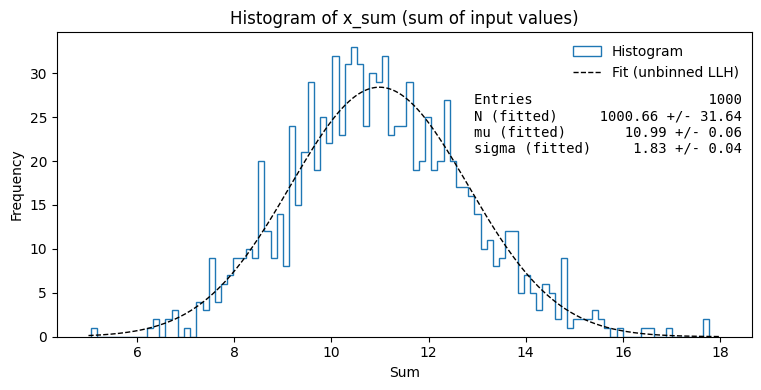

In [103]:
xmin, xmax = 5, 18
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize=(8, 4)) 
hist = ax.hist(x_sum, bins=Nbins, histtype='step', linewidth=1, label = 'Histogram')
x_ulfit = np.linspace(xmin, xmax, 1000)                                    # Create the x-axis for the plot of the fitted function
y_ulfit = binwidth * gauss_extended(x_ulfit, *minuit.values)
ax.plot(x_ulfit, y_ulfit, '--', color='black', linewidth=1, label='Fit (unbinned LLH)')
ax.legend(frameon = False) 
ax.set(xlabel='Sum', ylabel='Frequency', title='Histogram of x_sum (sum of input values)')

# Define figure text
d = {'Entries': len(x_sum),
     'N (fitted)': [minuit.values[0], minuit.errors[0]],
     'mu (fitted)': [minuit.values[1], minuit.errors[1]],
     'sigma (fitted)': [minuit.values[2], minuit.errors[2]]
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=2)
add_text_to_ax(0.6, 0.8, text, ax, fontsize=10)

fig.tight_layout()

fig.savefig("Gauss.png", dpi = 600)

In [106]:
def gauss_cdf(x):
    return stats.norm.cdf(x, minuit.values[1], minuit.values[2])

# if p<0.05 the distrubition is NOT gaussian
stats.kstest(x_sum, gauss_cdf, N=100)

KstestResult(statistic=0.026323514936964942, pvalue=0.48428778111192927)

In [102]:
xmin, xmax = 0.005, 1

def Integrand(x):
    return x * pdf_like(x)

x_expectation = np.array(quad(Integrand, xmin, xmax)) * 50
print(x_expectation)

[1.10190109e+01 7.03300027e-08]
